In [1]:
# from deap import base, creator, tools, algorithms
from dedalus import public as de
from dedalus.extras.plot_tools import plot_bot_2d
from dedalus.extras import *
import numpy as np
import scipy
from scipy import integrate, interpolate
from scipy.stats import linregress
import pickle
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd

import time as timeski
import os

#Suppress most Dedalus output
de.logging_setup.rootlogger.setLevel('ERROR')

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'arial'
# rcParams['font.sans-serif'] = ['Tahoma']
rcParams.update({'font.size': 12})

In [3]:
from scipy import interpolate

from skimage.measure import regionprops, label, regionprops_table

In [58]:
###################################################################
# Simulation Functions
###################################################################

#Scale list between 0 and 1
def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))

# steady state ODE
def ssODE(y,t,params):
    u,v,g,G = y
    b,gamma,n,delta,e,c,d= params
    
    du = b*v+v*gamma*u**n/(1+u**n)-delta*u-e*G*u
    dv = -du
    dG = c*u*g-d*G
    dg = - dG
    
    derivs = [du,dv,dg,dG]
    return derivs

#determine homogenous SS using ssODE
def homogenousSS(u,v,g,G,params):

    y0 = (u,v,g,G)
    t_sim = (0,1000)
    odeSoln = integrate.odeint(ssODE,y0,t_sim,args=(params,),mxstep=1000000) 
      
    return(odeSoln[1])

def WPGAP_2D(Du,domain_size,grid = 128,scale_factor = 1 ,DG_factor = 100):
#     b_SS,b_p, b_m, c_SS,c_p,c_m,delta,gamma_SS,gamma_p,gamma_m,e,d = params

    #Bases:names,modes,intervals,dealiasing
    x_basis=de.Fourier('x',grid,interval=(0,domain_size),dealias=3/2)
    y_basis=de.Chebyshev('y',grid,interval=(0,domain_size),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([x_basis,y_basis],float)
    x,y = domain.grids(scales=1)

    T = 4.04*scale_factor
    Tg = 10*scale_factor
    b = 0.1
    c = 1/scale_factor
    sigma = 1
    e = 1/scale_factor
    gamma = 2
    n = 2
    d = 1
    K = 1 *scale_factor

    Dv = 100*Du
    DG = DG_factor*Du 
    Dg = 100*Du

    p_ss = [b,gamma,n,sigma,e,c,d]
    u0,v0,g0,G0 = homogenousSS(T/2,T/2,Tg/2, Tg/2,p_ss)


    # Specify problem
    problem = de.IVP(domain, variables=['u', 'v','uy','vy','G','g','Gy','gy'])

    problem.parameters['u0'] = u0
    problem.parameters['v0'] = v0
    problem.parameters['G0'] = G0
    problem.parameters['g0'] = g0
    problem.parameters['Tg'] = Tg
    
    problem.parameters['gamma'] = gamma
    problem.parameters['b'] = b
    problem.parameters['n'] = n
    problem.parameters['c'] = c
    problem.parameters['dd'] = d
    problem.parameters['sigma'] = sigma
    problem.parameters['e'] = e
    problem.parameters['K'] = K
    

    problem.parameters['Du'] = Du
    problem.parameters['Dv'] = Dv
    problem.parameters['DG'] = DG
    problem.parameters['Dg'] = Dg
    
    problem.substitutions['f(u,v,G)'] = 'b*v+v*gamma*u**n/(K**n+u**n)-sigma*u-e*G*u'
    problem.substitutions['minf(u,v,G)'] = '-f(u,v,G)'
    problem.substitutions['fg(u,G,g)'] = 'c*u*g-dd*G'
    problem.substitutions['minfg(u,G,g)'] = '-fg(u,G,g)'

    problem.add_equation("dt(u)-Du*dx(dx(u))-Du*dy(uy)=f(u,v,G)")
    problem.add_equation("dt(v)-Dv*dx(dx(v))-Dv*dy(vy)=minf(u,v,G)")
    problem.add_equation("dt(G)-DG*dx(dx(G))-DG*dy(Gy)=fg(u,G,g)")
    problem.add_equation("dt(g)-Dg*dx(dx(g))-Dg*dy(gy)=minfg(u,G,g)")

    problem.add_equation("uy-dy(u)=0")
    problem.add_equation("vy-dy(v)=0")

    problem.add_equation("Gy-dy(G)=0")
    problem.add_equation("gy-dy(g)=0")

    # # Neumann boundary conditions

    problem.add_bc("left (uy) = 0")
    problem.add_bc("right (uy) = 0")
    problem.add_bc("left (vy) = 0")
    problem.add_bc("right (vy) = 0")
    problem.add_bc("left (Gy) = 0")
    problem.add_bc("right (Gy) = 0")
    problem.add_bc("left (gy) = 0")
    problem.add_bc("right (gy) = 0")


    # Pick a timestepper
    ts = de.timesteppers.RK443 #RK222
    # Build solver
    solver = problem.build_solver(ts)
    # Set integration limits
    solver.stop_wall_time = np.inf
    solver.stop_sim_time = np.inf
    solver.stop_iteration = np.inf
    # Set initial conditions
    u = solver.state ['u']
    v = solver.state['v']
    G = solver.state ['G']
    g = solver.state['g']

    # Random noise for initialization 
    urand = 0.2*v0*np.random.rand(*u['g'].shape)

    u['g'] = u0+urand
    v['g'] = v0-urand
    G['g'] = G0*np.ones(G['g'].shape)
    g['g'] = g0*np.ones(g['g'].shape)
    
    solver.stop_iteration = 1000 

    dt = 0.1 #0.25
    nonan = True
    # curr_t = 0
    # Main loop chceking stopping criteria
    while solver.ok and nonan:
        # Step forward
        solver.step(dt)
        # curr_t += dt

        if solver.iteration % 100 == 0:
            if np.count_nonzero(np.isnan(u['g'])) > 0 or np.min(u['g']) < 0 :
                return('Numerical Error')
                nonan = False 
    return [u['g'].T,v['g'].T]


In [104]:
#simulate WPGAP for variable Du
#redone so that regardless of spot size, the domain is large enough to have >100 spots

us = []
Dus = [1,0.5,0.1,0.05,0.03,0.01,0.005,0.004,0.003,0.001,0.0005]
domain_sizes = 40*10**(0.5*np.log10(Dus)+0.70)

for i,Du in enumerate(Dus):
    ds = domain_sizes[i]
    us.append(WPGAP_2D(Du,ds))

In [43]:


# for i,Du in enumerate(Dus):
    
#     x_basis=de.Fourier('x',64*2,interval=(0,domain_sizes[i]),dealias=3/2)
#     y_basis=de.Chebyshev('y',64*2,interval=(0,domain_sizes[i]),dealias=3/2)
#     #Domain:bases,datatype
#     domain=de.Domain([x_basis,y_basis],float)
# #     x,y = domain.grids(scales=1)

#     x,y = domain.grids(scales=domain.dealias)
#     # # phi = np.vstack((phi,2*np.pi))
#     X,Y = np.meshgrid(x,y)
#     # x,y = domain.grids(scales=1)
#     grid_x, grid_y = np.mgrid[0:domain_sizes[i]:128j, 0:domain_sizes[i]:128j]

#     plt.figure()
#     plt.title('Du = {}'.format(Du))
#     original_grid = np.vstack([X.flatten(),Y.flatten()]).T
#     grid_z0 = interpolate.griddata(original_grid, us[i].flatten(), (grid_x, grid_y), method='nearest')
#     plt.imshow(grid_z0,extent = [0,domain_sizes[i],0,domain_sizes[i]], vmin= 0.2, vmax = 0.8)
#     # plt.xticks([])
#     # plt.yticks([])
#     plt.colorbar()

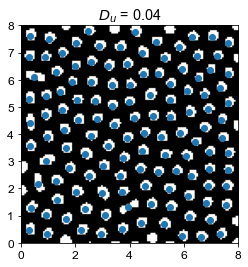

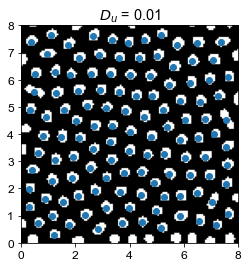

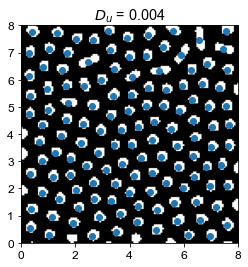

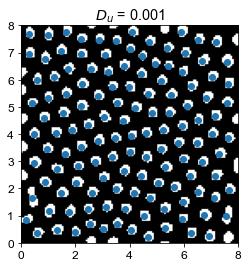

In [98]:
#get properties for spots 

dfs= []
for i,Du in enumerate(Dus):
    
    x_basis=de.Fourier('x',128,interval=(0,domain_sizes[i]),dealias=3/2)
    y_basis=de.Chebyshev('y',128,interval=(0,domain_sizes[i]),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([x_basis,y_basis],float)

    x,y = domain.grids(scales=domain.dealias)
    X,Y = np.meshgrid(x,y)
    grid_x, grid_y = np.mgrid[0:domain_sizes[i]:128j, 0:domain_sizes[i]:128j]

    plt.figure()
    plt.title('$D_u$ = {}'.format(Du))
    original_grid = np.vstack([X.flatten(),Y.flatten()]).T
    grid_z0 = interpolate.griddata(original_grid, us[i][0].flatten(), (grid_x, grid_y), method='nearest')

    
    # create labels for mask (midpoint between max and min values)
    labels = label(grid_z0 > (np.max(grid_z0)-np.min(grid_z0))/2)
    
    #get ellipse properties of masked objects
    regions = regionprops(labels)
    props = regionprops_table(labels, properties=('centroid',
                                                 'eccentricity',
                                                 'major_axis_length',
                                                 'minor_axis_length'))
    
    dx = domain_sizes[i]/128

    df = pd.DataFrame(props)
    df['centroid-0'] = df['centroid-0']*dx
    df['centroid-1'] = df['centroid-1']*dx
    df['major_axis_length'] = df['major_axis_length']*dx
    df['minor_axis_length'] = df['minor_axis_length']*dx
    
    #calculate effective mean radius
    r_eff = np.mean(
        [np.mean(df['major_axis_length']),np.mean(df['minor_axis_length'])]
    )/2
    
    #exclude spots that are too close to the edge
    keep_df = df[np.logical_and(df['centroid-0'] > r_eff , df['centroid-0'] < domain_sizes[i] - r_eff)]
    keep_df = keep_df[np.logical_and(keep_df['centroid-1'] > r_eff , keep_df['centroid-1'] < domain_sizes[i] - r_eff)]
    keep_df['r_eff'] = np.mean([keep_df['major_axis_length'],keep_df['minor_axis_length']],axis=0)/2

    plt.imshow(grid_z0 > (np.max(grid_z0)-np.min(grid_z0))/2, extent=[0,domain_sizes[i],0,domain_sizes[i]], origin='lower', cmap=plt.cm.gray)
    plt.scatter(keep_df['centroid-1'],keep_df['centroid-0'])
    
    dfs.append(keep_df)

In [93]:
r_effs = []
eccs = []
for df in dfs:
    r_effs.append(df['r_eff'].mean())
    eccs.append(df['eccentricity'].mean())
#     print(df.mean())

0.49652541166729375 0.6916737948995216 0.99971519667943 6.496659849881668e-16 0.003950940863272123


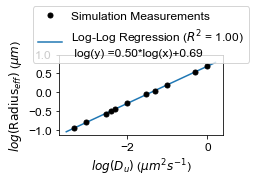

In [108]:
#log-log linear regression

plt.figure(figsize = (3.5,3))
A = Dus
B = r_effs

slope, intercept, r_value, p_value, std_err = linregress(np.log10(A), np.log10(B))
print(slope, intercept, r_value, p_value, std_err)


xfid = np.linspace(-3.5,0.2)     # This is just a set of x to plot the straight line 

plt.plot(np.log10(A),np.log10(B), 'k.',ms=10)
plt.plot(xfid, xfid*slope+intercept, zorder=0)

plt.yticks([-1,-0.5,0,0.5,1])
plt.xlabel('$log(D_u) $ ($\mu m^2 s^{-1}$)')
plt.ylabel('$log(\mathrm{Radius}_{eff})$ ($\mu m$)')
plt.legend(['Simulation Measurements', 'Log-Log Regression ($R^2$ = %.2f)\n log(y) =%.2f*log(x)+%.2f'%(r_value**2,slope,intercept)], \
           prop={"size":12},loc='center', bbox_to_anchor=(0.5,1.25))
plt.tight_layout()

# plt.savefig('Figures/Figure2/FigS2_Log_Log_Regression.pdf',dpi=300)
plt.show()

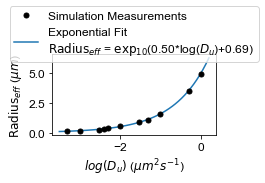

In [109]:
#linear regression on log(Du)

plt.figure(figsize = (3.5,3))
A = Dus
B = r_effs

# slope, intercept, r_value, p_value, std_err = linregress(np.log10(A), np.log10(B))
xfid = np.linspace(-3.5,0.2)     # This is just a set of x to plot the straight line 
# xfid = np.linspace(0,1)  

yfit = np.polyfit(np.log10(A),B, 1)

plt.plot(np.log10(A),B, 'k.',ms=10)
plt.plot(xfid, 10**(0.50*(xfid)+0.70),zorder=0)


plt.xlabel('$log(D_u) $ ($\mu m^2 s^{-1}$)')
plt.ylabel('$\mathrm{Radius}_{eff}$ ($\mu m$)')
plt.legend(['Simulation Measurements', 'Exponential Fit \n$\mathrm{Radius}_{eff}$ = $\mathrm{exp}_{10}$(%.2f*log($D_u$)+%.2f)'%(slope,intercept)],prop={"size":12}, \
          loc='center', bbox_to_anchor=(0.5,1.25))
plt.tight_layout()

# plt.savefig('Figures/Figure2/FigS2_Exponential.pdf',dpi=300)
plt.show()

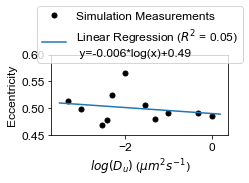

In [111]:
#linear regression on eccentricity

A = Dus
B = eccs

slope, intercept, r_value, p_value, std_err = linregress(np.log10(A), B)

xfid = np.linspace(-3.5,0.2)     # This is just a set of x to plot the straight line 

plt.figure(figsize = (3.5,3))
plt.plot(np.log10(A),B, 'k.',ms=10)
plt.plot(xfid, xfid*slope+intercept)

# plt.yticks([-0.4,-0.3,-0.2])
plt.yticks([0.45,0.5,0.55,0.60])
plt.xlabel('$log(D_u) $ ($\mu m^2 s^{-1}$)')
plt.ylabel('Eccentricity')
plt.legend(['Simulation Measurements', 'Linear Regression ($R^2$ = %.2f)\n y=%.3f*log(x)+%.2f'%(r_value**2,slope,intercept)],prop={"size":12},\
          loc='center', bbox_to_anchor=(0.5,1.25))
plt.tight_layout()

# plt.savefig('Figures/Figure2/FigS2_Eccentricity.pdf',dpi=300)
plt.show()

In [115]:
#simulate on the same domain size

us_same_domain = []
Dus = [0.04,0.01,0.004,0.001]
domain_sizes = 8*np.ones(len(Dus))

for i,Du in enumerate(Dus):
    ds = domain_sizes[i]
    us_same_domain.append(WPGAP_2D(Du,ds))

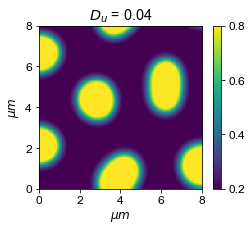

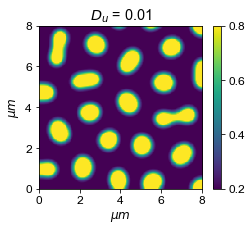

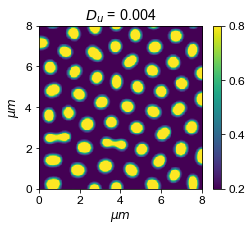

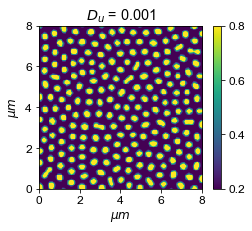

In [117]:
#individual plots

for i, Du in enumerate(Dus):

    x_basis=de.Fourier('x',64*2,interval=(0,domain_sizes[i]),dealias=3/2)
    y_basis=de.Chebyshev('y',64*2,interval=(0,domain_sizes[i]),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([x_basis,y_basis],float)
    x,y = domain.grids(scales=domain.dealias)
    X,Y = np.meshgrid(x,y)
    
    grid_x, grid_y = np.mgrid[0:8:128j, 0:8:128j]

    plt.figure(figsize=(4,3))
    plt.title('$D_u$ = {}'.format(Du))
    original_grid = np.vstack([X.flatten(),Y.flatten()]).T
    grid_z0 = interpolate.griddata(original_grid, us_same_domain[i][0].flatten(), (grid_x, grid_y), method='nearest')
#     plt.imshow(grid_z0,extent = [0,domain_sizes[i],0,domain_sizes[i]], vmin= 0.2, vmax = 0.8)
    plt.imshow(grid_z0,extent = [0,8,0,8], vmin= 0.2, vmax = 0.8)
    plt.ylabel('$\mu m$')
    plt.xlabel('$\mu m$')
    plt.colorbar()
#     plt.savefig('Figures/Figure2/FigS2_Spots_Du=%.4f.pdf'%Du,dpi=300)
    plt.show()


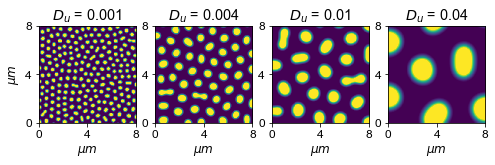

In [119]:
#single plot 

plt.figure(figsize = (8,3))

for i, Du in enumerate(Dus[::-1]):

    x_basis=de.Fourier('x',64*2,interval=(0,domain_sizes[i]),dealias=3/2)
    y_basis=de.Chebyshev('y',64*2,interval=(0,domain_sizes[i]),dealias=3/2)
    #Domain:bases,datatype
    domain=de.Domain([x_basis,y_basis],float)

    x,y = domain.grids(scales=domain.dealias)
    X,Y = np.meshgrid(x,y)
    
    grid_x, grid_y = np.mgrid[0:8:128j, 0:8:128j]

    plt.subplot(1,4,i+1)
    plt.title('$D_u$ = {}'.format(Du))
    original_grid = np.vstack([X.flatten(),Y.flatten()]).T
    grid_z0 = interpolate.griddata(original_grid, us_same_domain[3-i][0].flatten(), (grid_x, grid_y), method='nearest')
    plt.imshow(grid_z0,extent = [0,8,0,8], vmin= 0.2, vmax = 0.8)
    if i == 0:
        plt.ylabel('$\mu m$')
    plt.xlabel('$\mu m$')
    plt.xticks([0,4,8])
    plt.yticks([0,4,8])
#     plt.savefig('Figures/Figure2/FigS2_Spots_Du.pdf',dpi=300)
